# Basic Usage:
In this notebook you will find:
- How to get a survival curve and neighbors prediction using xgbse
- How to validate your xgbse model using sklearn

## Metrabic

We will be using the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) dataset from [pycox](https://github.com/havakv/pycox#datasets) as base for this example.

In [2]:
from pycox.datasets import metabric
import numpy as np

# getting data
df = metabric.read_df()

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


## Split and Time Bins

Split the data in train and test, using sklearn API. We also setup the TIME_BINS array, which will be used to fit the survival curve

In [3]:
from xgbse.converters import convert_to_structured
from sklearn.model_selection import train_test_split

# splitting to X, T, E format
X = df.drop(["duration", "event"], axis=1)
T = df["duration"]
E = df["event"]
y = convert_to_structured(T, E)

# splitting between train, and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=0
)
TIME_BINS = np.arange(15, 315, 15)
TIME_BINS

array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

## Fit and Predict

We will be using the DebiasedBCE estimator to fit the model and predict a survival curve for each point in our test data

In [4]:
from xgbse import XGBSEDebiasedBCE

# fitting xgbse model
xgbse_model = XGBSEDebiasedBCE(lr_params={"max_iter": 1500})
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS, num_boost_round=1000)

# predicting
y_pred = xgbse_model.predict(X_test)

print(y_pred.shape)
y_pred.head()

(635, 20)


,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.998988,0.995247,0.995218,0.994451,0.987990,0.979109,0.952899,0.952792,0.952138,0.952008,0.949860,0.892675,0.892507,0.840764,0.839172,0.734439,0.732219,0.726821,0.706943,0.699701
1,0.997263,0.944872,0.884912,0.674364,0.627228,0.566086,0.563968,0.047420,0.037309,0.037270,0.025956,0.011737,0.009772,0.008017,0.005553,0.003752,0.003745,0.001268,0.001236,0.001145
2,0.999541,0.999370,0.987968,0.987107,0.985423,0.983347,0.982598,0.976641,0.585108,0.558605,0.556056,0.552926,0.552171,0.546073,0.544894,0.510758,0.507372,0.481343,0.477759,0.412741
3,0.999970,0.999574,0.994848,0.989543,0.988840,0.988055,0.945365,0.944882,0.943819,0.939869,0.902530,0.845673,0.840188,0.838689,0.741230,0.724027,0.319774,0.317151,0.310076,0.299381
4,0.999423,0.999323,0.999034,0.996811,0.995542,0.731873,0.726610,0.725408,0.724736,0.717344,0.705641,0.705216,0.704165,0.696827,0.251091,0.244328,0.240177,0.208212,0.162117,0.087804


mean predicted survival curve for test data

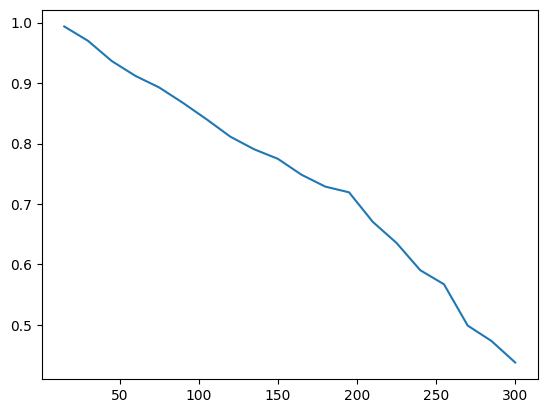

In [5]:
y_pred.mean().plot.line();

## Neighbors

We can also use our model for querying comparables based on survivability.

In [6]:
neighbors = xgbse_model.get_neighbors(
    query_data=X_test, index_data=X_train, n_neighbors=5
)

print(neighbors.shape)
neighbors.head(5)

(635, 5)


,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5
829,69,339,738,418,1589
670,1846,1082,1022,864,1358
1064,1252,739,416,1207,387
85,8,234,1522,1080,703
1814,105,1743,1168,1143,941


<b>example</b>: selecting a data point from query data (X_test) and checking its features

In [7]:
desired = neighbors.iloc[10]

X_test.loc[X_test.index == desired.name]

,x0,x1,x2,x3,x4,x5,x6,x7,x8
399,5.572504,7.367552,11.023443,5.406307,1.0,0.0,0.0,1.0,67.620003


... and finding its comparables from index data (X_train)

In [8]:
X_train.loc[X_train.index.isin(desired.tolist())]

,x0,x1,x2,x3,x4,x5,x6,x7,x8
1522,5.787038,6.713382,11.090166,5.551950,0.0,0.0,0.0,1.0,68.250000
703,5.823333,7.185800,10.898102,5.538811,0.0,0.0,0.0,1.0,66.540001
968,5.541239,7.058089,10.463409,5.396433,1.0,0.0,0.0,1.0,71.070000
1640,5.812605,7.646811,10.952687,5.516386,1.0,1.0,0.0,1.0,68.559998
234,5.784350,6.797296,11.025448,5.335426,1.0,1.0,0.0,1.0,68.489998


## Score metrics

XGBSE implements concordance index and integrated brier score, both can be used to evaluate model performance

In [9]:
# importing metrics
from xgbse.metrics import concordance_index, approx_brier_score

# running metrics
print(f"C-index: {concordance_index(y_test, y_pred)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, y_pred)}")

C-index: 0.6363746361184065
Avg. Brier Score: 0.26053716418501854


/Users/11488715/Desktop/xgboost-survival-embeddings/xgbse/non_parametric.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values


## Cross Validation

We can also use sklearn's cross_val_score and make_scorer to cross validate our model

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

results = cross_val_score(xgbse_model, X, y, scoring=make_scorer(approx_brier_score))
results

/Users/11488715/Desktop/xgboost-survival-embeddings/xgbse/non_parametric.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/11488715/Desktop/xgboost-survival-embeddings/xgbse/non_parametric.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/11488715/Desktop/xgboost-survival-embeddings/xgbse/non_parametric.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/11488715/Desktop/xgboost-survival-embeddings/xgbse/non_parametric.py:61: FutureWarning: DataFrame.f

array([0.17283962, 0.16673024, 0.13781023, 0.1772899 , 0.18112062])